# Get stationary time series 

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import multi_dot, norm
from random import seed
import utils
from cnn_graph.lib import graph

In [2]:
# Load data
dist_geo = pd.read_csv("data/distance_toulouse.csv",header=0,index_col=0)
X_hour = pd.read_csv("data/X_hour_toulouse.csv",header=0,index_col=0)
T_1, N = X_hour.shape
T_0 = int(X_hour.shape[0]*0.85)
T_tv = int(T_0*0.9)

## Weekly profile !only use the training set to get the profile!
X_train = X_hour.iloc[:T_tv,]
index = np.tile(np.arange(1,24*7+1), np.int(X_hour.shape[0]/24/7)+1)[:X_hour.shape[0]] - 1
X_train['index'] = index[:T_tv]
wk_pf = X_train.groupby('index').mean()
X_train = X_train.drop(columns = "index")

X_hour, wk_pf = [np.float32(x) for x in [X_hour, wk_pf]]
X_hour_detrend = np.copy(X_hour) - wk_pf[index,:]

## Scale, to make the regularization parameter lambda have the same influence on all var.
X_train = X_hour_detrend[:T_tv,]
sd = X_train.std(axis = 0)
X_hour_detrend_sc = np.multiply(X_hour_detrend , 1/sd)
X_train, X_val, X_test = [X_hour_detrend_sc[:T_tv,], X_hour_detrend_sc[T_tv:T_0,], X_hour_detrend_sc[T_0:,]]

In [3]:
# Sampling size is given
P = int(0.1*N)
print(P)

18


# Algorithm 3: H = 0
## Sensor selection on training set

In [66]:
# Input
## Build the graph
k = 20
dist, idx = graph.distance_sklearn_metrics(k = k, d = np.array(dist_geo))
A = graph.adjacency(dist, idx, k_self_tuning = 7).astype(np.float32)

## Construct the graph kernel
L = graph.laplacian(A, normalized=False)
K = utils.k_G(L.todense())

## Sample covariance
Sigma_hat = np.cov(X_train.T, bias=True)

### Hyperparameters $\lambda$ tuning
**Strategy**: When the computing power permits, we can select the best missing set $I_{\lambda}$ for every given hyperparameter setting $(\lambda)$ together with the corresponding reconstruction error on training set $F_{ \lambda}$. The ultimate sensor selection result is given by the set $I_{\lambda^*}$ whose $\lambda$ minimizes $F_{\lambda}$, and the ultimate selected reconstruction function is associated with the setting $\lambda^*$.

In [70]:
eig_max = utils.power_iteration(np.array(K), 10)    
Pi = eig_max*np.linspace(0.001, 0.01, num = 5)
err = []
I_collection = []
for lda in Pi:
    I, _ = utils.alg3(Sigma_hat, K, P, [lda])
    Ic = list(set(range(N)) - set(I)) 
    # Reconstruction on validation set
    [X_I_hat0, err_mse0] = utils.ReKer0(I = I, K = K, X = X_val[:,Ic], Y = X_val[:,I], lda = lda)
    print("The reconstruction error on the validation set is: {}.".format(err_mse0))
    err.append(err_mse0)
    I_collection.append(I)

power iteration:
The tolerance 0.100 has been reached. The number of iterations is: 5
The reconstruction error on the validation set is: 21.110690274778406.
The reconstruction error on the validation set is: 21.497459399860254.
The reconstruction error on the validation set is: 21.121606062644712.
The reconstruction error on the validation set is: 21.22626336704149.
The reconstruction error on the validation set is: 23.48001257849304.


0.011470618669088044 [46, 0, 98, 6, 24, 139, 11, 114, 71, 8, 4, 140, 28, 116, 15, 137, 142, 25]


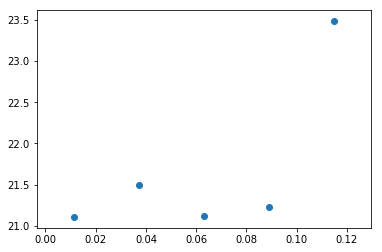

In [71]:
plt.rcParams["figure.figsize"] = (6,4)
plt.figure()
plt.scatter(Pi, err)

lda = Pi[np.argmin(err)]
I0 = I_collection[np.argmin(err)]
Ic0 = list(set(range(N)) - set(I0)) 
print(lda, I0)

## Reconstruction performance on test set

In [72]:
[X_I_hat0, err_mse0] = utils.ReKer0(I = I0, K = K, X = X_test[:,Ic0], Y = X_test[:,I0], lda = lda)
print("The reconstruction error on the test set is: {}.".format(err_mse0))

The reconstruction error on the test set is: 23.343111313830725.


## Comparison with baseline:  random sampling

In [73]:
err_mse_rand0 = np.zeros(100)
for i in range(100):
    I_rand = np.random.choice(N, P, replace=False)
    Ic_rand = list(set(range(N)) - set(I_rand)) 
    [_, err_mse_rand0[i]] = utils.ReKer0(I = I_rand, K = K, X = X_test[:,Ic_rand], Y = X_test[:,I_rand], lda = lda)
print("The average reconstruction error for random sampling set on the test set is: {}.".format(err_mse_rand0.mean()))

The average reconstruction error for random sampling set on the test set is: 28.403883752912943.


In [74]:
# Get the predictions of the original time series
X_I_hat0 = np.multiply(X_I_hat0, sd[I0]) # Multiply the std back
X_I_hat0 += wk_pf[index[T_0:],:][:,I0] # Add the trend back

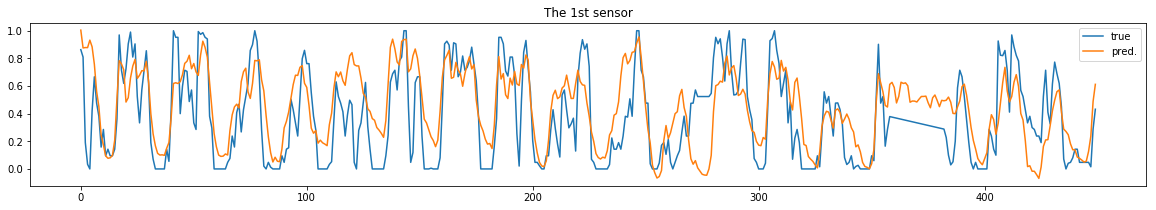

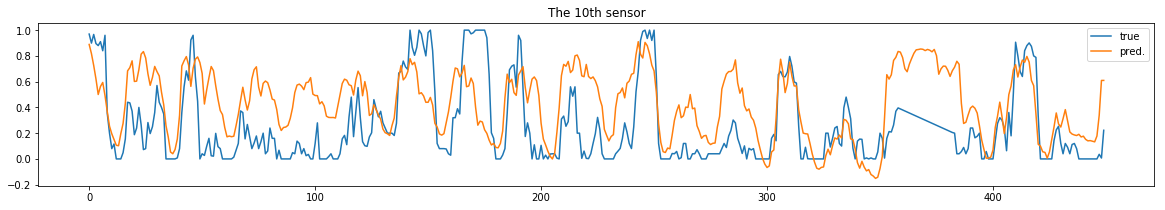

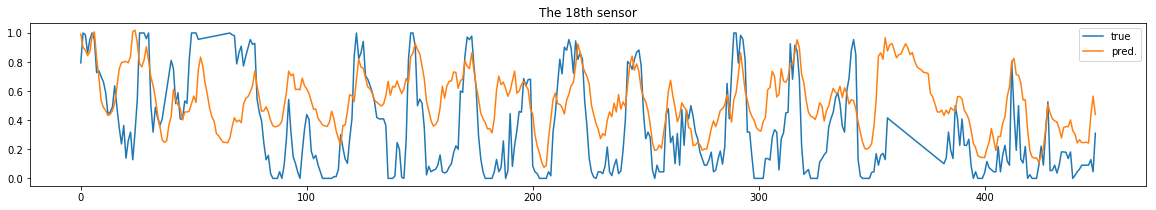

In [75]:
# Visualization
x = 450
plt.rcParams["figure.figsize"] = (20,3)
plt.figure()
plt.plot(X_hour[T_0:T_0+x,][:,I0][:,0], label = "true")
plt.plot(X_I_hat0[:x,0], label = "pred.")
plt.title("The 1st sensor")
plt.legend()
plt.figure()
plt.plot(X_hour[T_0:T_0+x,][:,I0][:,int(P/2)], label = "true")
plt.plot(X_I_hat0[:x,int(P/2)], label = "pred.")
plt.title("The {}th sensor".format(int(P/2)+1))
plt.legend()
plt.figure()
plt.plot(X_hour[T_0:T_0+x,][:,I0][:,P-1], label = "true")
plt.plot(X_I_hat0[:x,P-1], label = "pred.")
plt.title("The {}th sensor".format(P))
plt.legend()

# Algorithm 2/4: H > 0, with linear ridge regression
## Sensor selection on training set
### Hyperparameters $H, \gamma, \lambda$ tuning

**Strategy**: For a given hyperparameter setting $c = (H, \gamma, \lambda) \in C$, where $C$ is the searching grid, we select the best missing set $I_{c}$ together with the corresponding reconstruction error on training set $F_{c}$. The ultimate sensor selection result is given by the set $I_{c^*}$ whose $c$ minimizes $F_{c}$, and the ultimate selected reconstruction function is associated with the setting $c^*$.

**How to set the searching grid $C$?** 

- We first fix the searching grid of time lag $H$ as $G_H = [1, 5, 10]$. 

- For $\gamma$, because our kernel is defined as 
$$
k_{\mathcal{G} T}\left[\, (i,t),(j,t') \, \right] =  k_{\mathcal{G}}(i,j)\cdot k_{rbf}(t,t'), \qquad (1)
$$
where $k_{rbf}(t,t') = \exp\left[-\gamma\|\mathbf{x}-\textbf{y}\|^2_{\ell^2}\right]$, which measures the similarity between two data points $x_{it}, x_{jt'}$. To avoid the exponential decay from $k_{rbf}(t,t')$ cancelling out the past value of time lag $H$, namely $k_{rbf}(0,H) \approx 0$, we set $k_{rbf}(0,H)$ fixed as $0.5$, which furthermore determines the value of $\gamma = \frac{-\log(0.5)}{H^2}$.

- The way we determine the grid of $\lambda$ is inspired by the fact that: when using conjugate gradient method to inverse matrix $K_{\mathcal{S}}^H + \lambda I_d$, the complexity relies on its condition number, which is upper bounded by the condition number of $K_{\mathcal{N}}^H + \lambda I_d$, which is denoted as $\frac{\lambda_{max} + \lambda}{\lambda_{min} + \lambda}$, futhermore upper bounded by $\frac{\lambda_{max} + \lambda}{\lambda} = \frac{\lambda_{max}}{\lambda} + 1.$

Thus, after fixing $H$, we first use power method to estimate the largest eigenvalue $\lambda_{max}$ of $K_{\mathcal{N}}^H$, then set the searching grid for $\lambda$ proportional to $\lambda_{max}$, namely $\lambda \in \lambda_{max}[a, b]$, so as to keep the upperbound of condition number of $K_{\mathcal{S}}^H + \lambda I_d$ unchanged across $H$. 

Note that, for our kernel design $(1)$, the smallest eigenvalue of its gram matrix $K_{\mathcal{N}}^H$ is exactly $0$. Thus, $\frac{\lambda_{max} + \lambda}{\lambda_{min} + \lambda} = \frac{\lambda_{max}}{\lambda} + 1.$

In [90]:
grid = []
err = []
I_collection = []
G_H = [1, 5, 10]

for H in G_H:
    gamma = -np.log(0.3)/H**2 # To make sure exponential decay do not cancel out the past
    print("H = {:}, Gamma = {:3.3f}".format(H, gamma))
    St1 = [(j,0) for j in np.arange(N)]
    St2 = []
    for l in -np.arange(H+1):
        St2 += [(j,l) for j in np.arange(N)]
    KH = utils.btoep(utils.k_GT(L.todense(), gamma, St1, St2))
    
    # Estimate the largest eigenvalue so as to set the grid for lambda
    eig_max = utils.power_iteration(KH, 10)    
    Pi = eig_max*np.linspace(0.001, 0.01, num = 5)
    
    AlphaH = multi_dot([X_train[H:,:].T, X_train[H:,:]])
    for l_col in np.arange(H)+1:
        AlphaH = np.append(AlphaH, multi_dot([X_train[H:,:].T, X_train[(H-l_col):(T_tv-l_col),:]]), axis = 1) 
    AlphaH /= T_tv
    AlphaH = utils.btoep(AlphaH)
    
    for lda in Pi:
        I, _ = utils.alg4(Sigma_hat, KH, AlphaH, P, H, [lda], inv_method = 'cg', tol = 0.001*KH.std())
        Ic = list(set(range(N)) - set(I)) 
        # Reconstruction on validation set
        X_val_H_Ic = X_val[H:,Ic]
        T = X_val.shape[0]
        for l in np.arange(H)+1:
            X_val_H_Ic = np.append(X_val_H_Ic, X_val[(H-l):(T-l),Ic], axis = 1)
        [X_I_hat_H, err_mse_H] = utils.ReKerH(I, H, KH, X_val_H_Ic, X_val[H:,I], lda = lda, inv_method = 'cg', tol = 0.001*KH.std())

        print("Lambda is: {: 3.3f}, the reconstruction error on validation set is: {: 3.3f}. \n".format(lda, err_mse_H))
        grid.append((H, lda, gamma))
        err.append(err_mse_H)
        I_collection.append(I)
        
(H, lda, gamma) = grid[np.argmin(err)]
I = I_collection[np.argmin(err)]
Ic = list(set(range(N)) - set(I)) 
print(H, lda, gamma)
print(I)

H = 1, Gamma = 1.204
power iteration:
The tolerance 0.100 has been reached. The number of iterations is: 8
The percentage done is: 0.00
The percentage done is: 0.22
The percentage done is: 0.44
The percentage done is: 0.61
The percentage done is: 0.83
Lambda is:  0.015, the reconstruction error on validation set is:  21.074. 

The percentage done is: 0.00
The percentage done is: 0.22
The percentage done is: 0.44
The percentage done is: 0.61
The percentage done is: 0.83
Lambda is:  0.048, the reconstruction error on validation set is:  21.480. 

The percentage done is: 0.00
The percentage done is: 0.22
The percentage done is: 0.44
The percentage done is: 0.61
The percentage done is: 0.83
Lambda is:  0.082, the reconstruction error on validation set is:  21.100. 

The percentage done is: 0.00
The percentage done is: 0.22
The percentage done is: 0.44
The percentage done is: 0.61
The percentage done is: 0.83
Lambda is:  0.116, the reconstruction error on validation set is:  21.209. 

The p

## Reconstruction performance on test set

In [91]:
St1 = [(j,0) for j in np.arange(N)]
St2 = []
for l in -np.arange(H+1):
    St2 += [(j,l) for j in np.arange(N)]
KH = utils.btoep(utils.k_GT(L.todense(), gamma, St1, St2))

X_test_H_Ic = X_test[H:,Ic]
T = X_test.shape[0]
for l in np.arange(H)+1:
    X_test_H_Ic = np.append(X_test_H_Ic, X_test[(H-l):(T-l),Ic], axis = 1)  
[X_I_hat_H, err_mse_H] = utils.ReKerH(I, H, KH, X_test_H_Ic, X_test[H:,I], lda=lda, inv_method = 'cg', tol = 0.001*KH.std())

print("The reconstruction error on the test set is: {}.".format(err_mse_H))

The reconstruction error on the test set is: 18.629923889520185.


In [92]:
# Get the predictions of the original time series
X_I_hat_H = np.multiply(X_I_hat_H, sd[I]) # Multiply the std back
X_I_hat_H += wk_pf[index[T_0+H:],:][:,I] # Add the trend back

In [ ]:
## Visualization
# Visualization
x = 450
plt.rcParams["figure.figsize"] = (20,3)
plt.figure()
plt.plot(X_hour[T_0+H:T_0+H+x,][:,I][:,0], label = "true")
plt.plot(X_I_hat_H[:x,0], label = "pred.")
plt.title("The 1st sensor")
plt.legend()
plt.figure()
plt.plot(X_hour[T_0+H:T_0+H+x,][:,I][:,int(P/2)], label = "true")
plt.plot(X_I_hat_H[:x,int(P/2)], label = "pred.")
plt.title("The {}th sensor".format(int(P/2)+1))
plt.legend()
plt.figure()
plt.plot(X_hour[T_0+H:T_0+H+x,][:,I][:,P-1], label = "true")
plt.plot(X_I_hat_H[:x,P-1], label = "pred.")
plt.title("The {}th sensor".format(P))
plt.legend()

## Comparison with baseline:  random sampling

In [94]:
err_mse_rand_H = np.zeros(100)
for i in range(100):
    I_rand = np.random.choice(N, P, replace=False)
    Ic_rand = list(set(range(N)) - set(I_rand))     
    X_test_H_Ic = X_test[H:,Ic_rand]
    T = X_test.shape[0]
    for l in np.arange(H)+1:
        X_test_H_Ic = np.append(X_test_H_Ic, X_test[(H-l):(T-l),Ic_rand], axis = 1)        
    [X_I_hat_H_rand, err_mse_rand_H[i]] = utils.ReKerH(I_rand, H, KH, X_test_H_Ic, X_test[H:,I_rand], lda = lda, inv_method = 'cg')
print("The average reconstruction error for random sampling set on the test set is: {}.".format(err_mse_rand_H.mean()))

The average reconstruction error for random sampling set on the test set is: 20.460556220534624.
